# Chapter9  部分空間法による変化検知

今日の内容

- 扱うデータ：時系列データ
- 変化検知

変化検知とは

- Change Point detection
- Change Point problem

https://gdsdata.blog.gov.uk/2015/02/20/using-sentiment-scoring-and-changepoint-analysis-to-spot-problems-in-services/
from https://gdsdata.blog.gov.uk/2015/02/20/using-sentiment-scoring-and-changepoint-analysis-to-spot-problems-in-services/


9章の流れ

- 累積和法という古典技法を紹介
- 近傍法 (部分時系列の導入)
- 密度比問題への置き換え
- 特異スペクトル変換法
- 特異スペクトル変換の高速化

## 9.1 累積和法：変化検知の古典技術

例：化学プラントの反応器の中での特定の化学物質の濃度を時々刻々監視しているとする。

たまたま局所的に濃度が低かったり高かったりするのは避けられない。
2章のホテリングの$T^2$法のような「観測1回ごとにひとつひとつ異常度を計算する」タイプの監視技術は不適切かも

やりたいこと
単発で突発的に異常値が得られたというよりは、継続して何らかの異常状態が発生しているかどうかを検知すること、すなわち変化検知。

- $\xi$が正常時には安定して$\mu$という値を取る、正常時のモデルとして正規分布 $N(\xi|\mu, \sigma^2)$ と考えられる。
- 事前知識：正常値から上に$\nu_+$振れるようなら何かが起こっている

$\xi$の分散に大きな違いがないとすると、ここから次のモデルで表現できる

- 正常状態のモデル ${\mathcal N}(\xi | \mu, \sigma^2)$
- 異常状態のモデル ${\mathcal N}(\xi | \mu + \nu_+, \sigma^2)$

変化度の定義 = 単発の異常度を束ねて状態変化を表す指標に仕立てる

式1.2

$\displaystyle
a(x') = ln\frac{p(x'|y = 1, {\mathcal D})}{p(x'|y = 0, {\mathcal D})} {\tag{1.2}}
$

時刻$t$における単体の異常度 (式9.1は正誤あり)

$
\begin{align*}
  a(\xi^{(t)}) 
  & \equiv
  ln\frac{{\mathcal N}(\xi^{(t)}|\mu + \nu_+, \sigma^2)}{{\mathcal N}(\xi^{(t)}| \mu, \sigma^2)} {\tag{9.1}} \\
  & =
  (\frac{\nu_+}{\sigma})\frac{\xi^{(t)} - \mu - (\nu_+/2)}{\sigma} {\tag{9.2}}
\end{align*}
$

時刻$t$における変化度は

$
\begin{align*}
a^{(t)}_+
&\equiv
\Bigl[ a^{(t-1)}_+ + a(\xi^{(t)}) \Bigr]_+ {\tag{9.3}} \\
&=
\Bigl[ \bigl[ a^{(t-2)}_+ + a(\xi^{(t-1)}) \bigr]_+ + a(\xi^{(t)}) \Bigr]_+ \\
&=
\Bigl[ \bigl[ [a^{(t-3)}_+ + a(\xi^{(t-2)}) ]_+ + a(\xi^{(t-1)}) \bigr]_+ + a(\xi^{(t)}) \Bigr]_+ 
\end{align*}
$

時系列

${\mathcal D} = \{\xi^{(1)}, \xi^{(2)},...,\xi^{(T)}\}$

スライディングウィンドウ  
$x^{(1)} \equiv \left(
    \begin{array}{c}
      \xi^{(1)} \\
      \xi^{(2)} \\
      \vdots \\
      \xi^{(M)}
    \end{array}
  \right)
  ,
  x^{(2)} \equiv \left(
    \begin{array}{c}
      \xi^{(2)} \\
      \xi^{(3)} \\
      \vdots \\
      \xi^{(M+1)}
    \end{array}
  \right), \dots {\tag{9.5}}
$

## 時系列に対してK近傍を使った異常検知を適用してみると

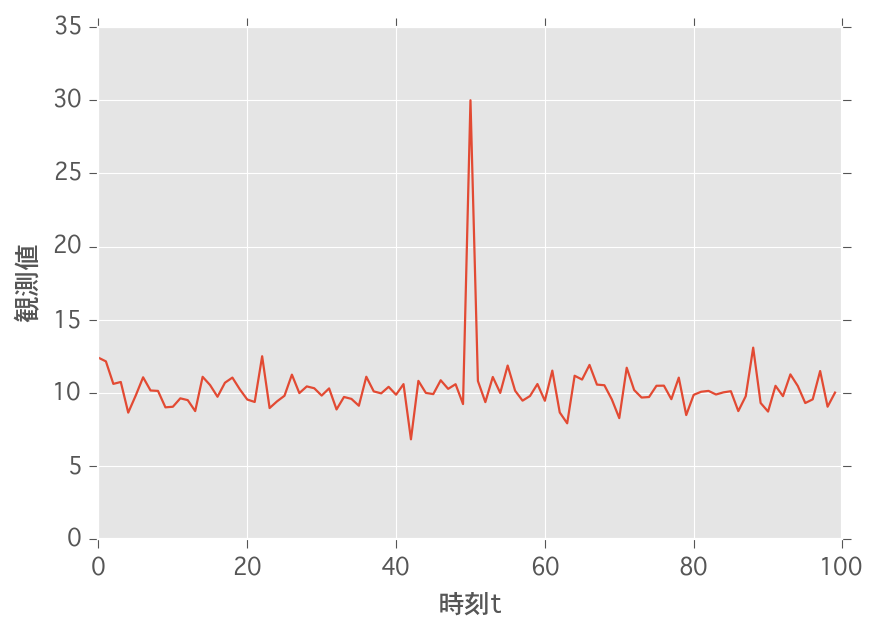

In [1]:
data = np.random.normal(10, 1, 100)
data[50] = 30
plt.plot(data)
plt.ylim(0, 35)
plt.xlabel(u'時刻t')
plt.ylabel(u'観測値')

In [2]:
windows = []
for idx in range(len(data)):
    if idx == len(data) - 1:
        break
    windows.append([data[idx], data[idx+1]])
windows = np.array(windows)

(5, 35)

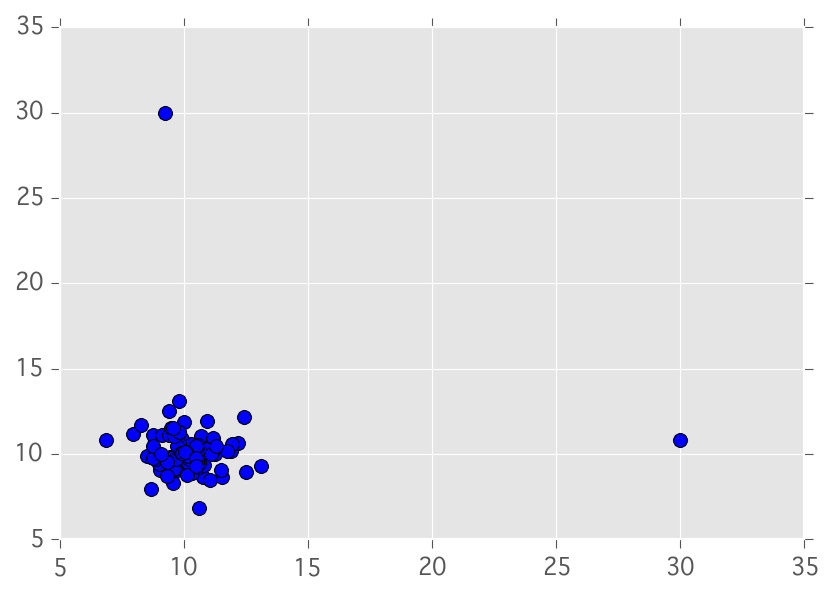

In [3]:
plt.plot(windows[:,0], windows[:,1], 'bo')
plt.xlim(5, 35)
plt.ylim(5, 35)

## 時系列データは直近のデータに相関を持つ

In [4]:
data = np.random.normal(10, 0.4, 400)
for idx, d in enumerate(data):
    if idx >= 100 and idx < 200:
        data[idx] = d + (idx-100)/5
    elif idx >= 200 and idx < 250:
        data[idx] = d + 20
    elif idx >= 250 and idx < 350:
        data[idx] = d + (350-idx)/5
    elif idx >= 300:
        pass

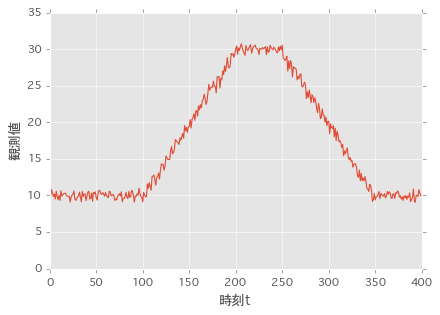

In [68]:
plt.plot(data)
plt.ylim(0, 35)
plt.xlabel(u'時刻t')
plt.ylabel(u'観測値')

(5, 35)

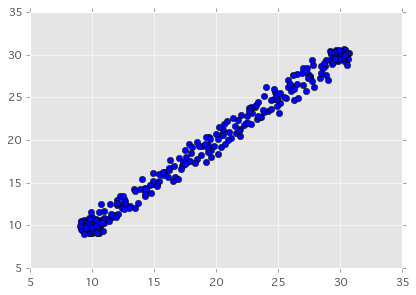

In [70]:
plt.plot(windows[:,0], windows[:,1], 'bo')
plt.xlim(5, 35)
plt.ylim(5, 35)

## 改めて確率分布の差として考えてみる

$\displaystyle
a^{(t)} = \int{dx}\ p^{(t)}(x)ln\frac{p^{(t)}(x)}{p\prime^{(t)}(x)} {\tag{9.8}}
$


ここで、部分時系列をフォンミーゼス分布とする


$\displaystyle
{\mathcal M}(x|\mu, \kappa) = \frac{\kappa^{M/2-1}}{(2\pi)^{M/2}I_{M/2-1}(\kappa)}exp(\kappa\mu^Tx)
$

$\displaystyle
p^{(t)}({\bf z}) = {\mathcal M}({\bf z}|{\bf u}^{(t)},\kappa),\ \ p\prime^{(t)}({\bf z}) = {\mathcal M}({\bf z}|{\bf q}^{(t)},\kappa)
$

フォンミーゼス分布の収束度パラメータが、変化前後で同じと仮定すると

$
\begin{align*}
a^{(t)} & = \int{dz}\  {\mathcal M}({\bf z} | {\bf u}^{(t)}, {\mathcal \kappa})\kappa{\bf z}^T({\bf u}^{(t)} - {\bf q}^{(t)}) \\
& = \kappa(1 - {\bf u}^{(t)T}{\bf q}^{(t)})  {\tag{9.9}}
\end{align*}
$

行列の微分について (PRMLの付録)

$\displaystyle
\frac{d}{d{\bf x}}({\bf x}^T{\bf a}) = \frac{d}{d{\bf x}}({\bf a}^T{\bf x}) = {\bf a}$

固有ベクトルとは

$A\bf{x} = \lambda\bf{x}$

http://qiita.com/kenmatsu4/items/2a8573e3c878fc2da306

固有ベクトルをnumpyで解く

In [87]:
A = np.array([[1,2],[3,4]])
print(u'行列A\n%s' % A)
eigen_values, eigen_vectors = np.linalg.eig(A)
print(u'固有値')
print(eigen_values)
print(u'固有ベクトル')
print eigen_vectors

行列A
[[1 2]
 [3 4]]
固有値
[-0.37228132  5.37228132]
固有ベクトル
[[-0.82456484 -0.41597356]
 [ 0.56576746 -0.90937671]]


$X{\bf \nu}_i = \sqrt{\gamma_i}{\bf u}_i,\ X^T{\bf u}_i = \sqrt{\gamma_i}{\bf \nu}_i {\tag{9.14}}$


\begin{align*}
{\bf U}_r^{(t)} & \equiv [{\bf u}^{(t,1)}, {\bf u}^{(t,2)}, \dots, {\bf u}^{(t,r)}] {\tag{9.18}} \\
{\bf Q}_m^{(t)} & \equiv [{\bf q}^{(t,1)}, {\bf q}^{(t,2)}, \dots, {\bf q}^{(t,m)}] {\tag{9.19}}
\end{align*} 

$
\displaystyle
\frac{d}{d\nu}\{{\bf \nu}^TX^{T}X{\bf \nu} - \gamma{\bf \nu}^T{\bf \nu}\} = 0
$

$
X^{T}X{\bf \nu} = \gamma{\bf \nu} {\tag{9.12}}
$

$
\begin{align*}
a(t) & = 1 - ||{\bf U}_r^{(t){\rm T}}{\bf Q}_m^{(t)}||_2 {\tag{9.21}} \\
& = 1 - ({\bf U}_r^{(t){\rm T}}{\bf Q}_m^{(t)}の最大特異値)
\end{align*}
$


心電図データ
http://www.cs.ucr.edu/~eamonn/discords/
からダウンロードできる

参考

- http://qiita.com/kokumura/items/e4c17d989aa3c34c6dd0

発展形

- ChangeFinder (計算コストが線形)